# Redes Neurais Convolucionais Para Classificação de Veículos

Neste projeto abordaremos a construção de redes neurais convolucionais (CNN) para classificação multiclasse de imagens de diversas classes de veículos usando o TensorFlow.

A visão computacional tem um impacto significativo em diversas áreas, melhorando a eficiência, a precisão e a segurança em uma variedade de aplicações. Ela permite que máquinas interpretem e reajam ao mundo visual de maneira semelhante (e, às vezes, até melhor) do que os seres humanos!

### Bibliotecas

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2 
import imghdr

import keras
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Limpando os dados adquiridos

Os dados são imagens coletadas de diversos sites de buscas, armazenados em pastas das suas respectivas classes. Estas são:
 
 - Bicicleta
 - Caminhão
 - Carro
 - Moto
 - ônibus

In [6]:
data_dir = 'dados'

img_ext = ['jpeg', 'jpg', 'bmp', 'png']

# Removendo imagens com extensões erradas:

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_ext:
                os.remove(image_path)
        except Exception as e:
            print('Erro')

Após remover todas imagens com extensões erradas, podemos carregar os dados.

### Carregando os dados

In [7]:
data = tf.keras.utils.image_dataset_from_directory('dados')
data.shuffle

Found 1670 files belonging to 5 classes.


<bound method DatasetV2.shuffle of <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

A ferramenta de carregamento do keras identificou as 5 classes através da separação de pastas nas quais as imagens estão armazenadas.

In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

print(f'número de imagens por batch e suas dimensões:\n{batch[0].shape}')

número de imagens por batch e suas dimensões:
(32, 256, 256, 3)


Visualizando exemplos dos dados e sua respectiva label:

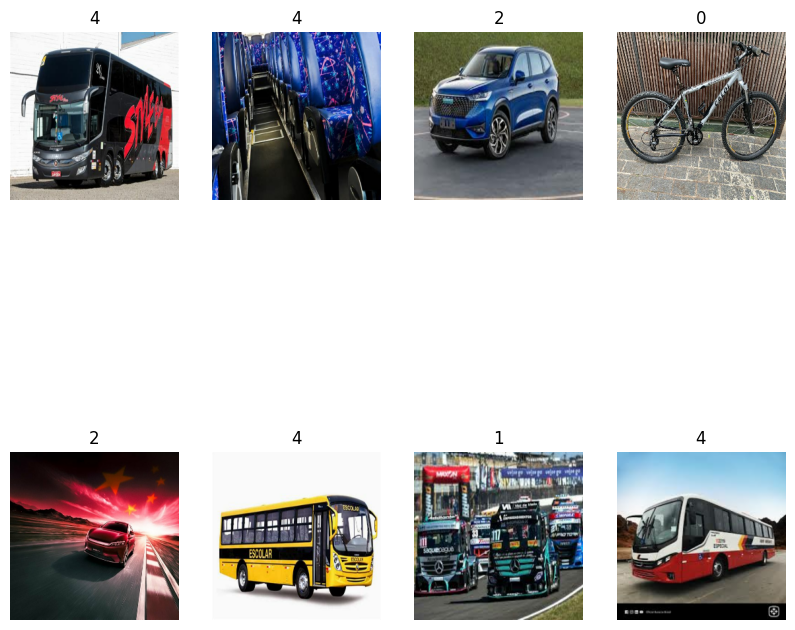

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
for indx, img in enumerate(batch[0][0:8]):
    ax[indx//4][indx%4].imshow(img.astype(int))
    ax[indx//4][indx%4].title.set_text(batch[1][indx])
    ax[indx//4][indx%4].axis('off')

In [10]:
label = {
    0:'Bicicleta',
    1:'Caminhão',
    2:'Carro',
    3:'Moto',
    4:'Ônibus'
}

print(label)

{0: 'Bicicleta', 1: 'Caminhão', 2: 'Carro', 3: 'Moto', 4: 'Ônibus'}


### Padronização dos dados

Para aumentar a eficiência e capacidade do nosso modelo, vamos padronizar as imagens:

In [11]:
batch[0].max(), batch[0].min()

(255.0, 0.0)

In [12]:
# função de padronização:

data = data.map(lambda x, y: (x/255, y))

# Valores das imagens estão padronizados entre 0 e 1

iterador_pad = data.as_numpy_iterator()

batch = iterador_pad.next()

batch[0].max(), batch[0].min()

(1.0, 0.0)

### Separando os dados

In [13]:
# Número de batchs

len(data)

53

In [14]:
train_size = int(len(data)*0.8)+1
val_size = int(len(data)*0.2)


print(f'batchs para treino: {train_size}\nbatchs para validação: {val_size}')

batchs para treino: 43
batchs para validação: 10


In [15]:
# Definindo o conjunto de treino e validação:

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

### Rede Convolucional

Antes de criar o modelo e treina-lo, devemos nos certificar que os dados não apresentam nenhum problema:

In [16]:
# Verificando os dados de treino:

for images, labels in train.take(1):
    print("Forma das imagens:", images.shape)
    print("Tipo de dados das imagens:", images.dtype)
    print("Existem valores NaN nas imagens?", tf.math.is_nan(images).numpy().any())

    print("Forma dos rótulos:", labels.shape)
    print("Tipo de dados dos rótulos:", labels.dtype)
    print("Existem 5 rótulos?", tf.math.equal(labels, 4).numpy().any())


Forma das imagens: (32, 256, 256, 3)
Tipo de dados das imagens: <dtype: 'float32'>
Existem valores NaN nas imagens? False
Forma dos rótulos: (32,)
Tipo de dados dos rótulos: <dtype: 'int32'>
Existem 5 rótulos? True


In [17]:
# Verificando os dados de validação:

for images, labels in val.take(1):
    print("Forma das imagens:", images.shape)
    print("Tipo de dados das imagens:", images.dtype)
    print("Existem valores NaN nas imagens?", tf.math.is_nan(images).numpy().any())

    print("Forma dos rótulos:", labels.shape)
    print("Tipo de dados dos rótulos:", labels.dtype)
    print("Existem 5 rótulos?", tf.math.equal(labels, 4).numpy().any())

Forma das imagens: (32, 256, 256, 3)
Tipo de dados das imagens: <dtype: 'float32'>
Existem valores NaN nas imagens? False
Forma dos rótulos: (32,)
Tipo de dados dos rótulos: <dtype: 'int32'>
Existem 5 rótulos? True


Em geral, as redes convolucionais são as mais adequadas para problemas de visão computacional. Um classificador de imagens convolucional é composto de duas partes principais:

 - Base convolucional
 - Dense head

Base: faz a extração das features, é feita principalmente de layers fazendo operações convolucionais

Head: É usada para determinar a classe da imagem, formada principalmente de dense layers.

In [18]:
modelo = Sequential([

    # Base

    layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same', 
                  input_shape=[256, 256, 3]),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'), 
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    # Head

    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=5, activation='softmax')

])

modelo.summary()

c:\Users\Daniels\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     4,194,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,200,357 (16.02 MB)

 Trainable params: 4,200,357 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Acima podemos observar as características do modelo.

Com o modelo criado, precisamos definir uma função para avaliar o erro das previsões do modelo e dos valores reais, e uma função que vai otimizar os parâmetros da rede a fim de diminuir este erro.

In [19]:
modelo.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

es = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

Early Stopping vai parar o treino quando o erro nos dados de validação pararem de diminuir. Evitando assim o overfitting do modelo.

### Treinando a rede

In [20]:
hist = modelo.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=[es],
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - loss: 2.6283 - sparse_categorical_accuracy: 0.3021 - val_loss: 1.3459 - val_sparse_categorical_accuracy: 0.4524
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.5626 - val_loss: 0.8962 - val_sparse_categorical_accuracy: 0.6463
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.7111 - val_sparse_categorical_accuracy: 0.7585
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step - loss: 0.3820 - sparse_categorical_accuracy: 0.8977 - val_loss: 0.5452 - val_sparse_categorical_accuracy: 0.8197
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8401
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.3751 - val_sparse_categorical_accuracy: 0.891

<Axes: >

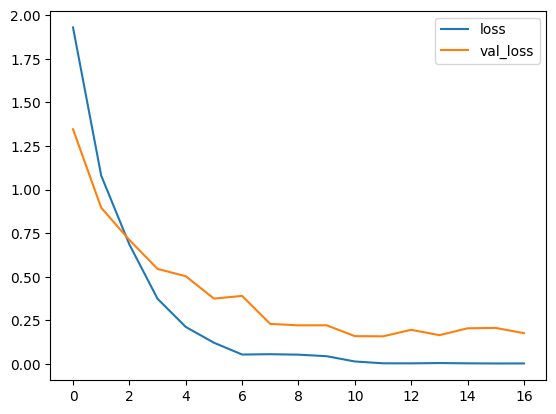

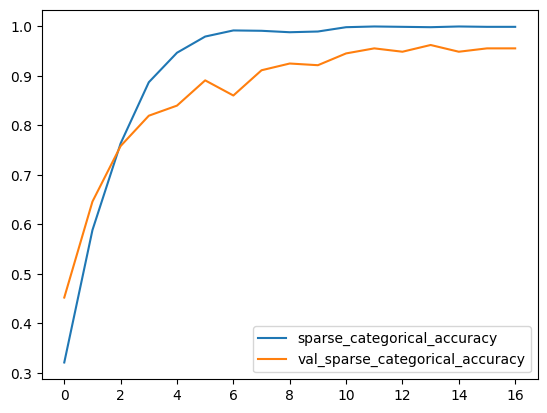

In [21]:
# Armazenando os resultados em um dataframe:

results_df = pd.DataFrame(hist.history)

results_df[['loss', 'val_loss']].plot()
results_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

No primeiro gráfico observamos a diminuição do erro validação e no segundo gráfico observamos o aumento na acurácia para o conjunto de treino e validação.

Em ambos os gráficos, temos melhora na qualidade do modelo de forma suave, a proximidade entre as curvas de treino e validação indicam uma boa capacidade do modelo de generalizar as previsões para dados não treinados.

### métricas de validação

In [22]:
# Obtendo os valores das labels das imagens e suas previões nos dados de validação:

true_labels = []
pred_labels = []

for images, labels in val:
    predictions = modelo.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_labels)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [23]:
# Armazenando as labels em um dataframe e calculando as métricas de validação:

df_res = pd.DataFrame({'y':true_labels, 'y_pred': pred_labels})

accuracy = accuracy_score(df_res['y'], df_res['y_pred'])
print(f'Acurácia: {round(accuracy,2)}\n')

print('Relatório de Classificação:\n')
print(classification_report(df_res['y'], df_res['y_pred']))


Acurácia: 0.95

Relatório de Classificação:

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.89      0.98      0.93        92
           2       0.98      0.94      0.96        53
           3       0.98      0.98      0.98        58
           4       0.95      0.86      0.90        49

    accuracy                           0.95       294
   macro avg       0.96      0.94      0.95       294
weighted avg       0.95      0.95      0.95       294



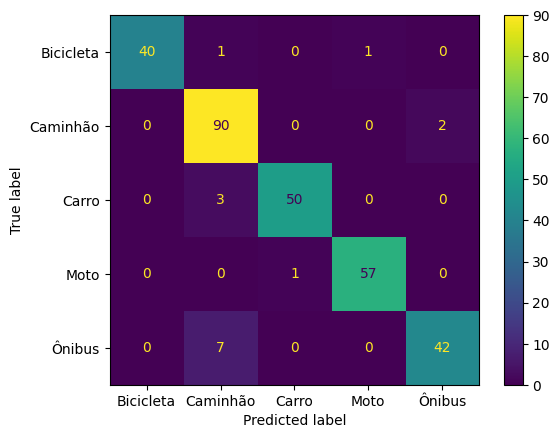

In [24]:
# Gerando uma matriz de confusão:

cm = confusion_matrix(df_res['y'], df_res['y_pred'])

matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.values())
matrix.plot()

Pela matriz de confusão acima notamos a alta capacidade do modelo de diferenciar e classificar corretamente as classes avaliadas nos dados de validação!

### Conclussões

Contruímos uma rede neural convolucional capaz de diferenciar e classificar corretamente diversas classes de veículos. As métricas de validação demonstram a qualidade do modelo apresentando uma acurácia alta. Concluíndo assim o objetivo inicial do projeto.